In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
# Import the function from the script
from join_function import merge_dataframes

In [4]:
flights = pd.read_csv("data/Flights.csv")
valid_airports = pd.read_csv("valid_airports.csv")
tickets = pd.read_csv("data/Tickets.csv")

/var/folders/5s/bzn_bky51k3bk9glk6bcxst40000gn/T/ipykernel_45866/1729188027.py:1: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv("data/Flights.csv")


In [5]:
# Create a list of valid IATA codes of medium and large airports
valid_iata_codes = valid_airports['IATA_CODE'].dropna().unique()

In [6]:
# Filter valid flights which belong to medium and large airports and dropping the rest
valid_flights = flights[
    (flights['ORIGIN'].isin(valid_iata_codes)) &
    (flights['DESTINATION'].isin(valid_iata_codes))
]

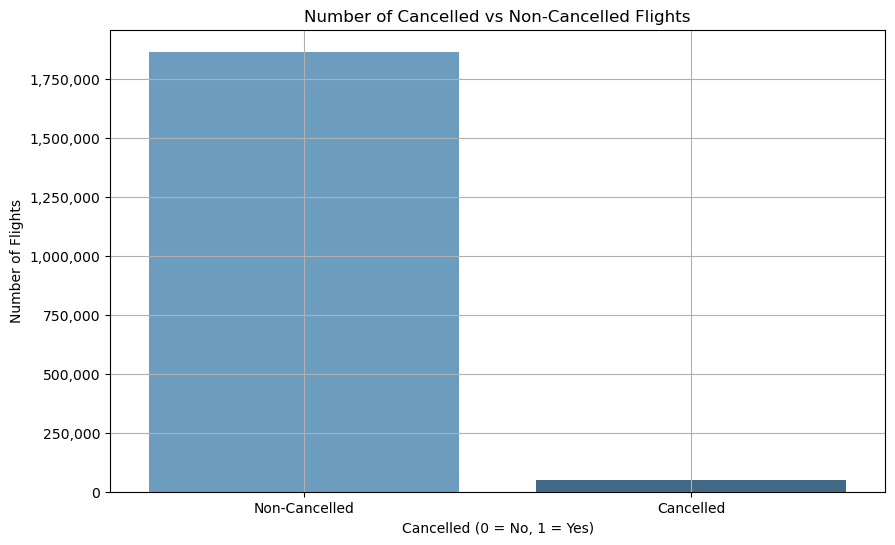

In [7]:
# Calculate the count of cancelled and non-cancelled flights
cancelled_counts = flights['CANCELLED'].value_counts().reset_index()
cancelled_counts.columns = ['CANCELLED', 'COUNT']
cancelled_counts

# Visualize the number of flights that were cancelled
plt.figure(figsize=(10, 6))
sns.barplot(x='CANCELLED', y='COUNT', data=cancelled_counts, palette='Blues_d')
plt.title('Number of Cancelled vs Non-Cancelled Flights')
plt.xlabel('Cancelled (0 = No, 1 = Yes)')
plt.ylabel('Number of Flights')
plt.xticks([0, 1], ['Non-Cancelled', 'Cancelled'])
# Set custom tick formatter to handle large numbers
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.grid(True)
plt.show()

In [8]:
#Removing flights which were cancelled

valid_flights = valid_flights.dropna(subset=['CANCELLED'])
valid_flights = valid_flights[valid_flights['CANCELLED'] == 0]
print("Number of flights after removing cancelled flights "+str(valid_flights.shape))

#checking for duplicate values and removing them
print("Duplicate flight rows "+str(valid_flights.duplicated().sum()))
valid_flights = valid_flights.drop_duplicates()
print("Number of flights after removing duplicates"+str(valid_flights.shape))



Number of flights after removing cancelled flights (1849732, 16)
Duplicate flight rows 4410
Number of flights after removing duplicates(1845322, 16)


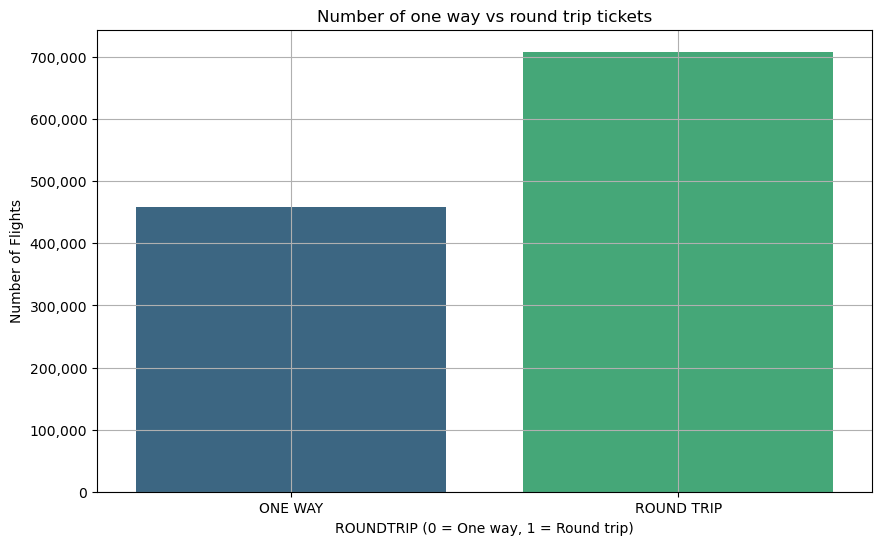

In [9]:
# Calculate the count of one way and round trip tickets
roundtrip_counts = tickets['ROUNDTRIP'].value_counts().reset_index()
roundtrip_counts.columns = ['ROUNDTRIP', 'COUNT']
roundtrip_counts

# Visualize the number of flights that were cancelled
plt.figure(figsize=(10, 6))
sns.barplot(x='ROUNDTRIP', y='COUNT', data=roundtrip_counts, palette='viridis')
plt.title('Number of one way vs round trip tickets')
plt.xlabel('ROUNDTRIP (0 = One way, 1 = Round trip)')
plt.ylabel('Number of Flights')
plt.xticks([0, 1], ['ONE WAY', 'ROUND TRIP'])
# Set custom tick formatter to handle large numbers
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.grid(True)
plt.show()

In [10]:
#Calculating average fare from tickets data

print("Total Number of tickets "+str(tickets.shape))
#Considering only round trip tickets
valid_tickets = tickets[tickets["ROUNDTRIP"] == 1]
print("Total Number of round trip tickets "+str(valid_tickets.shape))


Total Number of tickets (1167285, 12)
Total Number of round trip tickets (708600, 12)


In [11]:
#Calculating number of tickets for each origin and destination which will be used in the calculation of fare confidence
busiest_routes = valid_tickets.groupby(['ORIGIN', 'DESTINATION']).size().reset_index(name='total_tickets')

In [12]:
busiest_routes

,ORIGIN,DESTINATION,total_tickets
0,ABE,ABQ,2
1,ABE,AGS,1
2,ABE,AMA,1
3,ABE,ASE,2
4,ABE,ATL,52
...,...,...,...
40285,YUM,SMF,2
40286,YUM,SRQ,1
40287,YUM,TOL,2
40288,YUM,TPA,3


In [13]:
#Converting ITIN FARE column to numeric for average calculation
valid_tickets['ITIN_FARE'] = pd.to_numeric(valid_tickets['ITIN_FARE'], errors='coerce')
#Removing rows of empty ITIN FARE
valid_tickets = valid_tickets.dropna(subset=['ITIN_FARE'])

/var/folders/5s/bzn_bky51k3bk9glk6bcxst40000gn/T/ipykernel_45866/1893991194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_tickets['ITIN_FARE'] = pd.to_numeric(valid_tickets['ITIN_FARE'], errors='coerce')


In [14]:
valid_tickets['ROUTE'] = valid_tickets['ORIGIN'] + '-' + valid_tickets['DESTINATION']

In [15]:
# Function to identify outliers using IQR technique
def identify_outliers(group):
    Q1 = group['ITIN_FARE'].quantile(0.25)
    Q3 = group['ITIN_FARE'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (group['ITIN_FARE'] < Q1 - 1.5 * IQR) | (group['ITIN_FARE'] > Q3 + 1.5 * IQR)
    return group.loc[filter]

In [16]:
# Identify outliers from ITIN_FARE
outliers = valid_tickets.groupby(['ORIGIN', 'DESTINATION']).apply(identify_outliers).reset_index(drop=True)

# Get top 20 outliers by ITIN_FARE value
top_outliers = outliers.nlargest(20, 'ITIN_FARE')

# Filter valid_tickets to include only rows with ROUTEs that are in the top_outliers to simplify the plot as the data is very huge and its not possible to plot all the outliers together
filtered_valid_tickets = valid_tickets[valid_tickets['ROUTE'].isin(top_outliers['ROUTE'].unique())]




/var/folders/5s/bzn_bky51k3bk9glk6bcxst40000gn/T/ipykernel_45866/1746836960.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = valid_tickets.groupby(['ORIGIN', 'DESTINATION']).apply(identify_outliers).reset_index(drop=True)


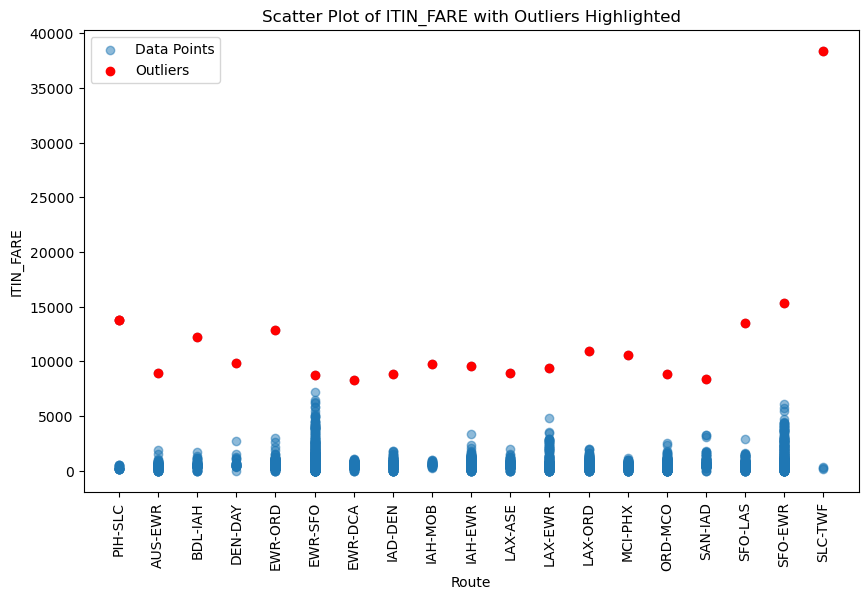

In [17]:
#Creating scatter plot to visualise the outliers in ITIN FARE
plt.figure(figsize=(10, 6))
plt.scatter(filtered_valid_tickets['ROUTE'], filtered_valid_tickets['ITIN_FARE'], label='Data Points', alpha=0.5)
plt.scatter(top_outliers['ROUTE'], top_outliers['ITIN_FARE'], color='red', label='Outliers', marker='o')
plt.xticks(rotation=90)
plt.title('Scatter Plot of ITIN_FARE with Outliers Highlighted')
plt.xlabel('Route')
plt.ylabel('ITIN_FARE')
plt.legend()
plt.show()

In [18]:
#Interquartile range function implementation to remove outliers

def remove_outliers(group):
    Q1 = group['ITIN_FARE'].quantile(0.25)
    Q3 = group['ITIN_FARE'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (group['ITIN_FARE'] >= Q1 - 1.5 * IQR) & (group['ITIN_FARE'] <= Q3 + 1.5 * IQR)
    return group.loc[filter]

In [19]:
#Removing outliers from ITIN Fare
valid_tickets = valid_tickets.groupby(['ORIGIN', 'DESTINATION']).apply(remove_outliers).reset_index(drop=True)

/var/folders/5s/bzn_bky51k3bk9glk6bcxst40000gn/T/ipykernel_45866/2405959654.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_tickets = valid_tickets.groupby(['ORIGIN', 'DESTINATION']).apply(remove_outliers).reset_index(drop=True)


In [20]:
#Calculating frequency of tickets between origin and destination after removing outliers
frequency_tickets = valid_tickets.groupby(['ORIGIN', 'DESTINATION']).size().reset_index(name='total_tickets')


In [21]:
frequency_tickets

,ORIGIN,DESTINATION,total_tickets
0,ABE,ABQ,2
1,ABE,AGS,1
2,ABE,AMA,1
3,ABE,ASE,2
4,ABE,ATL,52
...,...,...,...
40263,YUM,SMF,2
40264,YUM,SRQ,1
40265,YUM,TOL,2
40266,YUM,TPA,3


In [30]:
#Calculating average fare between origin and destination and renaming ITIN FARE with AVERAGE_ITIN_FARE
grouped_valid_tickets = valid_tickets.groupby(['ORIGIN', 'DESTINATION'])['ITIN_FARE'].mean().reset_index()
grouped_valid_tickets.rename(columns={'ITIN_FARE': 'AVERAGE_ITIN_FARE'}, inplace=True)

In [31]:
grouped_valid_tickets

,ORIGIN,DESTINATION,AVERAGE_ITIN_FARE
0,ABE,ABQ,534.000000
1,ABE,AGS,299.000000
2,ABE,AMA,654.000000
3,ABE,ASE,742.000000
4,ABE,ATL,505.038462
...,...,...,...
40263,YUM,SMF,276.500000
40264,YUM,SRQ,696.000000
40265,YUM,TOL,335.000000
40266,YUM,TPA,544.333333


/Users/tanmaybhardwaj/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


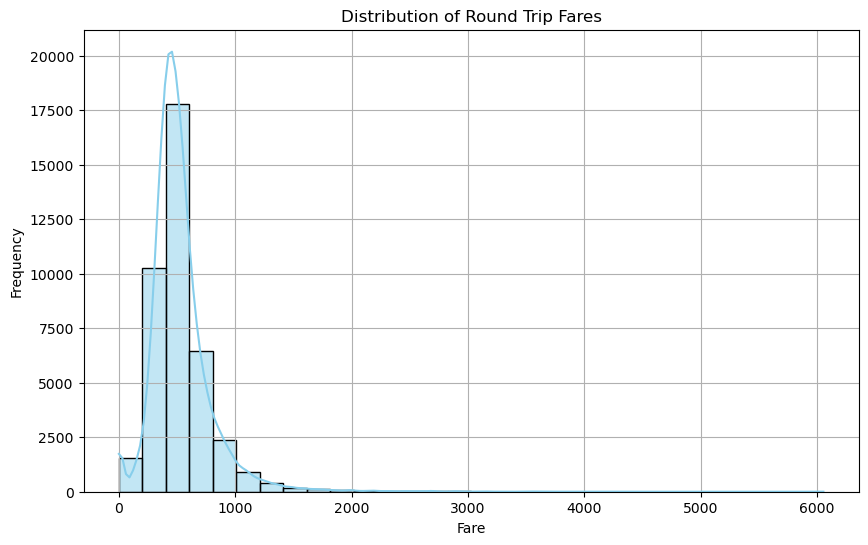

In [32]:
# Visualize the distribution of round trip fares
plt.figure(figsize=(10, 6))
sns.histplot(grouped_valid_tickets["AVERAGE_ITIN_FARE"], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Round Trip Fares')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [33]:
#Merging with grouped valid tickets to keep a record of number of tickets between origin and destination along with avg fare

grouped_valid_tickets = merge_dataframes(grouped_valid_tickets,frequency_tickets,['ORIGIN','DESTINATION'],how='left')

In [34]:
grouped_valid_tickets

,ORIGIN,DESTINATION,AVERAGE_ITIN_FARE,total_tickets
0,ABE,ABQ,534.000000,2
1,ABE,AGS,299.000000,1
2,ABE,AMA,654.000000,1
3,ABE,ASE,742.000000,2
4,ABE,ATL,505.038462,52
...,...,...,...,...
40263,YUM,SMF,276.500000,2
40264,YUM,SRQ,696.000000,1
40265,YUM,TOL,335.000000,2
40266,YUM,TPA,544.333333,3


In [35]:
#Confidence level calculation to know how many flights there are for a particular fare

#Max number of flights 
max_total_ticket = max(grouped_valid_tickets['total_tickets'])

In [36]:
grouped_valid_tickets_with_confidence = grouped_valid_tickets.copy()

grouped_valid_tickets_with_confidence['confidence'] = (grouped_valid_tickets_with_confidence['total_tickets'] / max_total_ticket) * 100

In [37]:
grouped_valid_tickets_with_confidence.sort_values(by='confidence',ascending = False)

,ORIGIN,DESTINATION,AVERAGE_ITIN_FARE,total_tickets,confidence
20033,JFK,LAX,689.829487,780,100.000000
27994,ORD,LGA,339.940195,719,92.179487
26394,MSP,PHX,359.254676,695,89.102564
26357,MSP,MCO,362.767004,691,88.589744
27988,ORD,LAX,433.186047,688,88.205128
...,...,...,...,...,...
15517,GPT,JAX,528.000000,1,0.128205
15514,GPT,ICT,764.000000,1,0.128205
32312,RNO,GSP,403.000000,1,0.128205
15511,GPT,HRL,0.000000,1,0.128205


In [38]:
valid_flights

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.970000
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.550000
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.910000
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.670000
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911336,3/23/19,AA,N903NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.794884
1911337,3/24/19,AA,N965AN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-2.0,-1.0,0.0,106,****,0.538399
1911338,3/25/19,AA,N979NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-8.0,-25.0,0.0,106,****,0.955579
1911339,3/26/19,AA,N872NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.595344


In [39]:
#Merging flights information with average fare,confidence value and number of tickets for a particular origin and destination

valid_flights_with_fare = merge_dataframes(valid_flights,grouped_valid_tickets_with_confidence,['ORIGIN','DESTINATION'],how='left')

In [40]:
valid_flights_with_fare

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,AVERAGE_ITIN_FARE,total_tickets,confidence
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.970000,186.169231,65.0,8.333333
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.550000,211.625000,48.0,6.153846
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.910000,211.625000,48.0,6.153846
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.670000,211.625000,48.0,6.153846
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.620000,405.545455,11.0,1.410256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845317,3/23/19,AA,N903NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.794884,530.962963,27.0,3.461538
1845318,3/24/19,AA,N965AN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-2.0,-1.0,0.0,106,****,0.538399,530.962963,27.0,3.461538
1845319,3/25/19,AA,N979NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-8.0,-25.0,0.0,106,****,0.955579,530.962963,27.0,3.461538
1845320,3/26/19,AA,N872NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.595344,530.962963,27.0,3.461538


/Users/tanmaybhardwaj/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tanmaybhardwaj/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


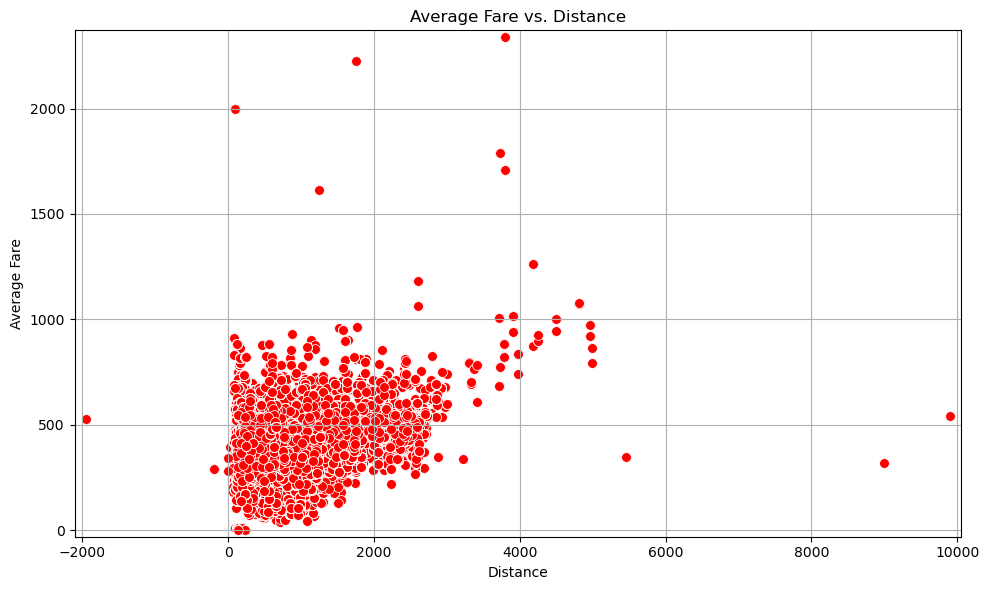

In [91]:
distance_fare_df = valid_flights_with_fare.loc[:, ['DISTANCE','AVERAGE_ITIN_FARE']]

# Convert columns to numeric, coercing errors to NaN
distance_fare_df['DISTANCE'] = pd.to_numeric(distance_fare_df['DISTANCE'], errors='coerce')
distance_fare_df['AVERAGE_ITIN_FARE'] = pd.to_numeric(distance_fare_df['AVERAGE_ITIN_FARE'], errors='coerce')

# Drop rows with NaN values in DISTANCE or AVERAGE_ITIN_FARE
distance_fare_df = distance_fare_df.dropna(subset=['DISTANCE', 'AVERAGE_ITIN_FARE'])

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a scatter plot with density contours
sns.kdeplot(x='DISTANCE', y='AVERAGE_ITIN_FARE', data=distance_fare_df, fill=True, cmap='Blues')
sns.scatterplot(x='DISTANCE', y='AVERAGE_ITIN_FARE', data=distance_fare_df, color='red', s=50)
plt.title('Average Fare vs. Distance')
plt.xlabel('Distance')
plt.ylabel('Average Fare')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [33]:
#Dropping total tickets taken from tickets because its of no use after calculation of average fare
valid_flights_with_fare = valid_flights_with_fare.drop(columns=['total_tickets'])

#Renaming confidence to fare_confidence
valid_flights_with_fare = valid_flights_with_fare.rename(columns={'confidence' : 'fare_confidence'})

In [34]:
valid_flights_with_fare

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,AVERAGE_ITIN_FARE,fare_confidence
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.970000,186.169231,8.333333
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.550000,211.625000,6.153846
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.910000,211.625000,6.153846
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.670000,211.625000,6.153846
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.620000,405.545455,1.410256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845317,3/23/19,AA,N903NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.794884,530.962963,3.461538
1845318,3/24/19,AA,N965AN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-2.0,-1.0,0.0,106,****,0.538399,530.962963,3.461538
1845319,3/25/19,AA,N979NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-8.0,-25.0,0.0,106,****,0.955579,530.962963,3.461538
1845320,3/26/19,AA,N872NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.595344,530.962963,3.461538


In [35]:
#Creating two new columns to know the type of origin and destination airport which will eventually help in calculating revenue
valid_flights_with_fare = valid_flights_with_fare.merge(valid_airports, left_on='ORIGIN', right_on='IATA_CODE', how='inner')
valid_flights_with_fare = valid_flights_with_fare.merge(valid_airports, left_on='DESTINATION', right_on='IATA_CODE', suffixes=('_origin', '_dest'), how='inner')


In [36]:
valid_flights_with_fare

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,AVERAGE_ITIN_FARE,fare_confidence,Unnamed: 0_origin,TYPE_origin,NAME_origin,IATA_CODE_origin,Unnamed: 0_dest,TYPE_dest,NAME_dest,IATA_CODE_dest
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,186.169231,8.333333,29959,large_airport,Southwest Florida International Airport,RSW,26546,large_airport,Cleveland Hopkins International Airport,CLE
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",...,211.625000,6.153846,29959,large_airport,Southwest Florida International Airport,RSW,26556,large_airport,John Glenn Columbus International Airport,CMH
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",...,211.625000,6.153846,29959,large_airport,Southwest Florida International Airport,RSW,26556,large_airport,John Glenn Columbus International Airport,CMH
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",...,211.625000,6.153846,29959,large_airport,Southwest Florida International Airport,RSW,26556,large_airport,John Glenn Columbus International Airport,CMH
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",...,405.545455,1.410256,29959,large_airport,Southwest Florida International Airport,RSW,26680,large_airport,Dallas Love Field,DAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845317,3/23/19,AA,N903NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",...,530.962963,3.461538,30305,large_airport,Tulsa International Airport,TUL,26553,large_airport,Charlotte Douglas International Airport,CLT
1845318,3/24/19,AA,N965AN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",...,530.962963,3.461538,30305,large_airport,Tulsa International Airport,TUL,26553,large_airport,Charlotte Douglas International Airport,CLT
1845319,3/25/19,AA,N979NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",...,530.962963,3.461538,30305,large_airport,Tulsa International Airport,TUL,26553,large_airport,Charlotte Douglas International Airport,CLT
1845320,3/26/19,AA,N872NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",...,530.962963,3.461538,30305,large_airport,Tulsa International Airport,TUL,26553,large_airport,Charlotte Douglas International Airport,CLT


In [37]:
#Dropping irrelevant columns
valid_flights_with_fare = valid_flights_with_fare.drop(columns=['IATA_CODE_origin','IATA_CODE_dest','OP_CARRIER','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','NAME_origin','NAME_dest','ORIGIN_CITY_NAME','DEST_AIRPORT_ID','DEST_CITY_NAME','CANCELLED','Unnamed: 0_dest','Unnamed: 0_origin'])

In [38]:
valid_flights_with_fare

,FL_DATE,ORIGIN,DESTINATION,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,AVERAGE_ITIN_FARE,fare_confidence,TYPE_origin,TYPE_dest
0,2019-03-02,RSW,CLE,-8.0,-6.0,143.0,1025.0,0.970000,186.169231,8.333333,large_airport,large_airport
1,2019-03-02,RSW,CMH,1.0,5.0,135.0,930.0,0.550000,211.625000,6.153846,large_airport,large_airport
2,2019-03-02,RSW,CMH,0.0,4.0,132.0,930.0,0.910000,211.625000,6.153846,large_airport,large_airport
3,2019-03-02,RSW,CMH,11.0,14.0,136.0,930.0,0.670000,211.625000,6.153846,large_airport,large_airport
4,2019-03-02,RSW,DAL,0.0,-17.0,151.0,1005.0,0.620000,405.545455,1.410256,large_airport,large_airport
...,...,...,...,...,...,...,...,...,...,...,...,...
1845317,3/23/19,TUL,CLT,-9.0,-6.0,112,****,0.794884,530.962963,3.461538,large_airport,large_airport
1845318,3/24/19,TUL,CLT,-2.0,-1.0,106,****,0.538399,530.962963,3.461538,large_airport,large_airport
1845319,3/25/19,TUL,CLT,-8.0,-25.0,106,****,0.955579,530.962963,3.461538,large_airport,large_airport
1845320,3/26/19,TUL,CLT,-9.0,-6.0,112,****,0.595344,530.962963,3.461538,large_airport,large_airport


In [39]:
#Functions to calculate revenue and cost for each flight

def calculate_revenue(row):
    ticket_revenue = row['OCCUPANCY_RATE'] * 200 * row['AVERAGE_ITIN_FARE']
    baggage_revenue = row['OCCUPANCY_RATE'] * 200 * 0.5 * 70
    return ticket_revenue + baggage_revenue

def calculate_cost(row):
    distance_cost = (row['DISTANCE'] * (8 + 1.18))
    airport_cost = 5000 * (row['TYPE_origin'] == 'medium_airport') + 10000 * (row['TYPE_origin'] == 'large_airport') + 5000 * (row['TYPE_dest'] == 'medium_airport') + 10000 * (row['TYPE_dest'] == 'large_airport')
    delay_cost = max(0, row['DEP_DELAY'] - 15) * 75 + max(0, row['ARR_DELAY'] - 15) * 75
    return distance_cost + airport_cost + delay_cost

In [40]:
#creating copy of valid flights with fare to add new columns of cost,revenue and profit
final_profit_data = valid_flights_with_fare.copy()

In [41]:
# Ensure DISTANCE, DEP_DELAY, and ARR_DELAY columns are numeric
final_profit_data['DISTANCE'] = pd.to_numeric(final_profit_data['DISTANCE'], errors='coerce')
final_profit_data['DEP_DELAY'] = pd.to_numeric(final_profit_data['DEP_DELAY'], errors='coerce')
final_profit_data['ARR_DELAY'] = pd.to_numeric(final_profit_data['ARR_DELAY'], errors='coerce')

In [42]:
final_profit_data['revenue'] = final_profit_data.apply(calculate_revenue, axis=1)
final_profit_data['cost'] = final_profit_data.apply(calculate_cost, axis=1)
final_profit_data['profit'] = final_profit_data['revenue'] - final_profit_data['cost']

In [43]:
final_profit_data

,FL_DATE,ORIGIN,DESTINATION,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,AVERAGE_ITIN_FARE,fare_confidence,TYPE_origin,TYPE_dest,revenue,cost,profit
0,2019-03-02,RSW,CLE,-8.0,-6.0,143.0,1025.0,0.970000,186.169231,8.333333,large_airport,large_airport,42906.830769,29409.5,13497.330769
1,2019-03-02,RSW,CMH,1.0,5.0,135.0,930.0,0.550000,211.625000,6.153846,large_airport,large_airport,27128.750000,28537.4,-1408.650000
2,2019-03-02,RSW,CMH,0.0,4.0,132.0,930.0,0.910000,211.625000,6.153846,large_airport,large_airport,44885.750000,28537.4,16348.350000
3,2019-03-02,RSW,CMH,11.0,14.0,136.0,930.0,0.670000,211.625000,6.153846,large_airport,large_airport,33047.750000,28537.4,4510.350000
4,2019-03-02,RSW,DAL,0.0,-17.0,151.0,1005.0,0.620000,405.545455,1.410256,large_airport,large_airport,54627.636364,29225.9,25401.736364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845317,3/23/19,TUL,CLT,-9.0,-6.0,112,NaN,0.794884,530.962963,3.461538,large_airport,large_airport,89975.035895,NaN,NaN
1845318,3/24/19,TUL,CLT,-2.0,-1.0,106,NaN,0.538399,530.962963,3.461538,large_airport,large_airport,60942.727496,NaN,NaN
1845319,3/25/19,TUL,CLT,-8.0,-25.0,106,NaN,0.955579,530.962963,3.461538,large_airport,large_airport,108164.471568,NaN,NaN
1845320,3/26/19,TUL,CLT,-9.0,-6.0,112,NaN,0.595344,530.962963,3.461538,large_airport,large_airport,67388.563218,NaN,NaN


In [44]:
#Checking Null values in profit section as some rows have missing fare information, so calculation of profit cannot be done
print(final_profit_data["profit"].isna().sum())

#Dropping these rows as these missing values are less than 2% of the while data
final_profit_data = final_profit_data.dropna(subset=["profit"])

In [45]:
final_profit_data

,FL_DATE,ORIGIN,DESTINATION,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,AVERAGE_ITIN_FARE,fare_confidence,TYPE_origin,TYPE_dest,revenue,cost,profit
0,2019-03-02,RSW,CLE,-8.0,-6.0,143.0,1025.0,0.970000,186.169231,8.333333,large_airport,large_airport,42906.830769,29409.50,13497.330769
1,2019-03-02,RSW,CMH,1.0,5.0,135.0,930.0,0.550000,211.625000,6.153846,large_airport,large_airport,27128.750000,28537.40,-1408.650000
2,2019-03-02,RSW,CMH,0.0,4.0,132.0,930.0,0.910000,211.625000,6.153846,large_airport,large_airport,44885.750000,28537.40,16348.350000
3,2019-03-02,RSW,CMH,11.0,14.0,136.0,930.0,0.670000,211.625000,6.153846,large_airport,large_airport,33047.750000,28537.40,4510.350000
4,2019-03-02,RSW,DAL,0.0,-17.0,151.0,1005.0,0.620000,405.545455,1.410256,large_airport,large_airport,54627.636364,29225.90,25401.736364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845122,3/11/19,DFW,BDL,7.0,-17.0,$$$,1471.0,0.311332,690.986301,9.358974,large_airport,large_airport,45204.536302,33503.78,11700.756302
1845123,3/12/19,DFW,BDL,62.0,60.0,$$$,1471.0,0.553687,690.986301,9.358974,large_airport,large_airport,80393.814541,40403.78,39990.034541
1845124,3/14/19,DFW,BDL,-4.0,-21.0,$$$,1471.0,0.403534,690.986301,9.358974,large_airport,large_airport,58592.026000,33503.78,25088.246000
1845125,3/15/19,DFW,BDL,42.0,15.0,$$$,1471.0,0.786213,690.986301,9.358974,large_airport,large_airport,114156.028622,35528.78,78627.248622


In [46]:
#Saving this data to use in the calculations of recommended routes
final_profit_data.to_csv("all_flights_profits_data.csv")

In [47]:
#adding revenue,cost and profit value between one route to determine most profitable round trip routes
profitable_round_trips = final_profit_data.groupby(['ORIGIN', 'DESTINATION','fare_confidence'])[['cost','revenue','profit']].sum().reset_index()

In [48]:
profitable_round_trips

,ORIGIN,DESTINATION,fare_confidence,cost,revenue,profit
0,ABE,ATL,6.666667,4898780.52,1.503683e+07,1.013805e+07
1,ABE,CLT,3.333333,5129585.58,1.836060e+07,1.323101e+07
2,ABE,DTW,1.153846,5281647.00,1.265807e+07,7.376421e+06
3,ABE,FLL,6.666667,527352.60,6.432646e+05,1.159120e+05
4,ABE,ORD,2.179487,3882816.48,1.316046e+07,9.277643e+06
...,...,...,...,...,...,...
5618,YAK,CDV,0.256410,1077568.22,4.739840e+05,-6.035842e+05
5619,YAK,JNU,2.820513,1118852.32,4.421452e+06,3.302599e+06
5620,YKM,SEA,2.051282,5301389.70,1.083388e+07,5.532489e+06
5621,YUM,DFW,0.512821,759569.88,1.763484e+06,1.003914e+06


In [49]:
#Getting number of flights for a particular route
total_round_trip_flights = pd.read_csv("Busiest_routes_flights.csv")
total_round_trip_flights

,ORIGIN,DESTINATION,total_flights
0,ABE,ATL,217
1,ABE,CLT,251
2,ABE,DTW,248
3,ABE,FLL,20
4,ABE,ORD,159
...,...,...,...
5726,YAK,CDV,83
5727,YAK,JNU,88
5728,YKM,SEA,305
5729,YUM,DFW,28


In [50]:
#Merging profits data with number of flights 
profitable_round_trips = profitable_round_trips.merge(total_round_trip_flights,on=['ORIGIN','DESTINATION'],how='left')


In [53]:
profitable_round_trips['ROUTE'] = profitable_round_trips['ORIGIN'] + '-' + profitable_round_trips['DESTINATION']

In [55]:
top_10_profitable_routes = profitable_round_trips.nlargest(10,'profit')

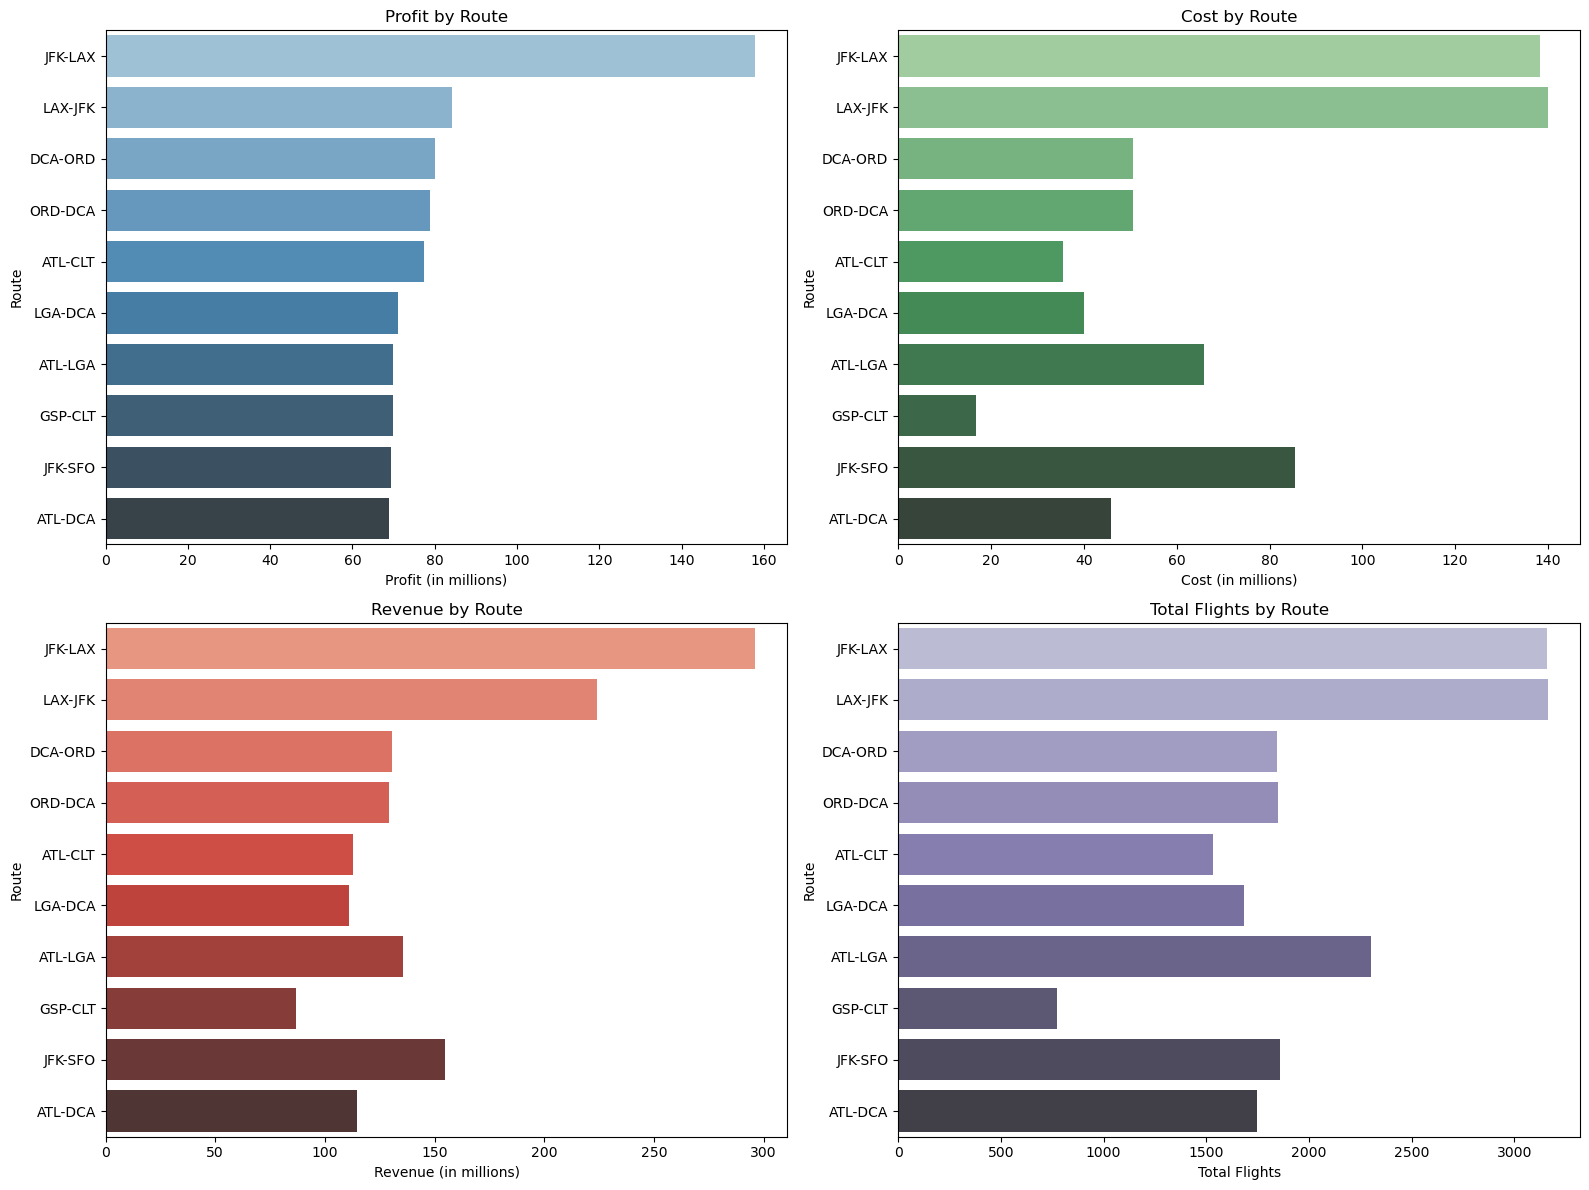

In [58]:
# Scale values to millions
top_10_profitable_routes['cost'] = top_10_profitable_routes['cost'] / 1e6
top_10_profitable_routes['revenue'] = top_10_profitable_routes['revenue'] / 1e6
top_10_profitable_routes['profit'] = top_10_profitable_routes['profit'] / 1e6

# Set the size of the entire figure
plt.figure(figsize=(16, 12))

# Plot 1: Profit
plt.subplot(2, 2, 1)
sns.barplot(x='profit', y='ROUTE', data=top_10_profitable_routes, palette='Blues_d')
plt.title('Profit by Route')
plt.xlabel('Profit (in millions)')
plt.ylabel('Route')

# Plot 2: Cost
plt.subplot(2, 2, 2)
sns.barplot(x='cost', y='ROUTE', data=top_10_profitable_routes, palette='Greens_d')
plt.title('Cost by Route')
plt.xlabel('Cost (in millions)')
plt.ylabel('Route')

# Plot 3: Revenue
plt.subplot(2, 2, 3)
sns.barplot(x='revenue', y='ROUTE', data=top_10_profitable_routes, palette='Reds_d')
plt.title('Revenue by Route')
plt.xlabel('Revenue (in millions)')
plt.ylabel('Route')

# Plot 4: Total Flights
plt.subplot(2, 2, 4)
sns.barplot(x='total_flights', y='ROUTE', data=top_10_profitable_routes, palette='Purples_d')
plt.title('Total Flights by Route')
plt.xlabel('Total Flights')
plt.ylabel('Route')

plt.tight_layout()
plt.show()